# Does greenness correlate with the number of viable/desirable transitions?
Felix Zaussinger | 04.06.2021

## Core Analysis Goal(s)
1. Assess whether greenness correlates with the number of viable/desirable
transitions as calculated by Kanders 2019

## Key Insight(s)
1. No, greenness does not explain the number of viable/desirable transitions

In [1]:
import os
import sys
import logging
from pathlib import Path

import numpy as np
import scipy as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.iolib.summary2 import summary_col
from stargazer.stargazer import Stargazer
from scipy.stats import kendalltau, pearsonr, spearmanr

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("paper")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("ticks")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

Define directory structure

In [2]:
# project directory
abspath = os.path.abspath('')
project_dir = str(Path(abspath).parents[0])

# sub-directories
data_raw = os.path.join(project_dir, "data", "raw")
data_interim = os.path.join(project_dir, "data", "interim")
data_processed = os.path.join(project_dir, "data", "processed")
figure_dir = os.path.join(project_dir, "reports", "figures")

Read merged data set

In [3]:
df = pd.read_csv(
    os.path.join(data_interim, "ESCO_ONET_METADATA.csv"),
    index_col=0
)

n_green_occ = df.shape[0] - df.greenness_vona_2018.isna().sum()

df.greenness_vona_2018 = df.greenness_vona_2018.fillna(0)

# convert job zone to categorical var
df.job_zone = pd.Categorical(df.job_zone, ordered=True)

cols_numeric = [
    'concept_uri', 'greenness_vona_2018_v2', 'total_paid_hours',
    'annual_earnings', 'employment_share', 'employment_count', 'job_zone',
    'education_level', 'related_work_experience', 'on_the_job_training',
    'net_change_ilo_2030_es', 'net_change_ilo_2030_ce'
]

df_numeric = df[cols_numeric]

### Read data on number of viable/desirable transitions by Kanders 2019
caveat: only available for 1627 of 2942 occupations

In [4]:
fpath_n_transitions_kanders = os.path.join(data_raw, "mcc_data", "processed", "transitions", "ESCO_number_of_transitions.csv")

n_transitions_kanders = pd.read_csv(fpath_n_transitions_kanders, index_col=0)

n_transitions_kanders


,concept_uri,preferred_label,isco_level_4,risk_category,n_desirable,n_desirable_and_highly_viable,n_safe_desirable,n_safe_desirable_and_highly_viable,n_safe_desirable_strict,n_safe_desirable_strict_and_highly_viable
id,,,,,,,,,,
1,http://data.europa.eu/esco/occupation/000e93a3...,metal drawing machine operator,8121,Lower risk,142,103,142,103,2,0
3,http://data.europa.eu/esco/occupation/0022f466...,air traffic safety technician,3155,Lower risk,27,1,27,1,10,0
4,http://data.europa.eu/esco/occupation/002da35b...,hospitality revenue manager,2431,Lower risk,85,9,67,8,3,0
5,http://data.europa.eu/esco/occupation/0044c991...,medical laboratory assistant,3212,Lower risk,22,5,21,5,2,0
7,http://data.europa.eu/esco/occupation/00674f21...,primary school teaching assistant,5312,Lower risk,27,23,25,21,0,0
...,...,...,...,...,...,...,...,...,...,...
2935,http://data.europa.eu/esco/occupation/ff5210a5...,cosmetics production machine operator,8131,Lower risk,96,10,95,10,7,1
2937,http://data.europa.eu/esco/occupation/ff656b3a...,demographer,2120,High risk,40,21,34,19,29,18
2938,http://data.europa.eu/esco/occupation/ff8d4065...,sorter labourer,9612,Lower risk,8,3,8,3,1,0


Merge

In [5]:
df_merged = pd.merge(
    left=n_transitions_kanders,
    right=df_numeric,
    on="concept_uri",
    how="left"
)

df_merged

,concept_uri,preferred_label,isco_level_4,risk_category,n_desirable,n_desirable_and_highly_viable,n_safe_desirable,n_safe_desirable_and_highly_viable,n_safe_desirable_strict,n_safe_desirable_strict_and_highly_viable,greenness_vona_2018_v2,total_paid_hours,annual_earnings,employment_share,employment_count,job_zone,education_level,related_work_experience,on_the_job_training,net_change_ilo_2030_es,net_change_ilo_2030_ce
0,http://data.europa.eu/esco/occupation/000e93a3...,metal drawing machine operator,8121,Lower risk,142,103,142,103,2,0,NaN,39.904110,22031.963636,0.000020,645.0,2.0,2.1163,2.4383,3.6486,678000.0,-5588500.0
1,http://data.europa.eu/esco/occupation/0022f466...,air traffic safety technician,3155,Lower risk,27,1,27,1,10,0,NaN,42.036716,32754.000000,0.000087,2797.0,3.0,4.3848,5.4808,4.0782,734000.0,260000.0
2,http://data.europa.eu/esco/occupation/002da35b...,hospitality revenue manager,2431,Lower risk,85,9,67,8,3,0,NaN,36.354676,38839.816377,0.000648,20834.0,4.0,6.8261,6.3481,3.8265,72000.0,784000.0
3,http://data.europa.eu/esco/occupation/0044c991...,medical laboratory assistant,3212,Lower risk,22,5,21,5,2,0,NaN,35.246809,21517.582278,0.000647,20808.0,3.0,5.7431,4.5363,3.9548,4000.0,206500.0
4,http://data.europa.eu/esco/occupation/00674f21...,primary school teaching assistant,5312,Lower risk,27,23,25,21,0,0,NaN,27.634427,15945.319226,0.004302,138321.0,3.0,3.6277,3.9765,2.7602,-27000.0,-28000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1622,http://data.europa.eu/esco/occupation/ff5210a5...,cosmetics production machine operator,8131,Lower risk,96,10,95,10,7,1,0.047619,39.965625,22211.820144,0.000053,1699.0,2.0,2.0478,3.9646,3.1842,678000.0,-5588500.0
1623,http://data.europa.eu/esco/occupation/ff656b3a...,demographer,2120,High risk,40,21,34,19,29,18,NaN,35.494487,36135.290249,0.000286,9184.0,5.0,8.3000,5.5000,4.6000,516000.0,877000.0
1624,http://data.europa.eu/esco/occupation/ff8d4065...,sorter labourer,9612,Lower risk,8,3,8,3,1,0,1.000000,39.443972,21357.054545,0.000417,13414.0,2.0,3.1532,3.3559,2.8314,288000.0,1041000.0
1625,http://data.europa.eu/esco/occupation/ffade2f4...,civil service administrative officer,2422,Lower risk,17,2,13,2,0,0,NaN,35.240566,33292.986333,0.001128,36261.0,3.0,3.9636,6.9711,3.4248,72000.0,784000.0


(<Figure size 1080x1080 with 2 Axes>,
 <AxesSubplot:title={'center':'pearsonr, p < 0.0500'}>)

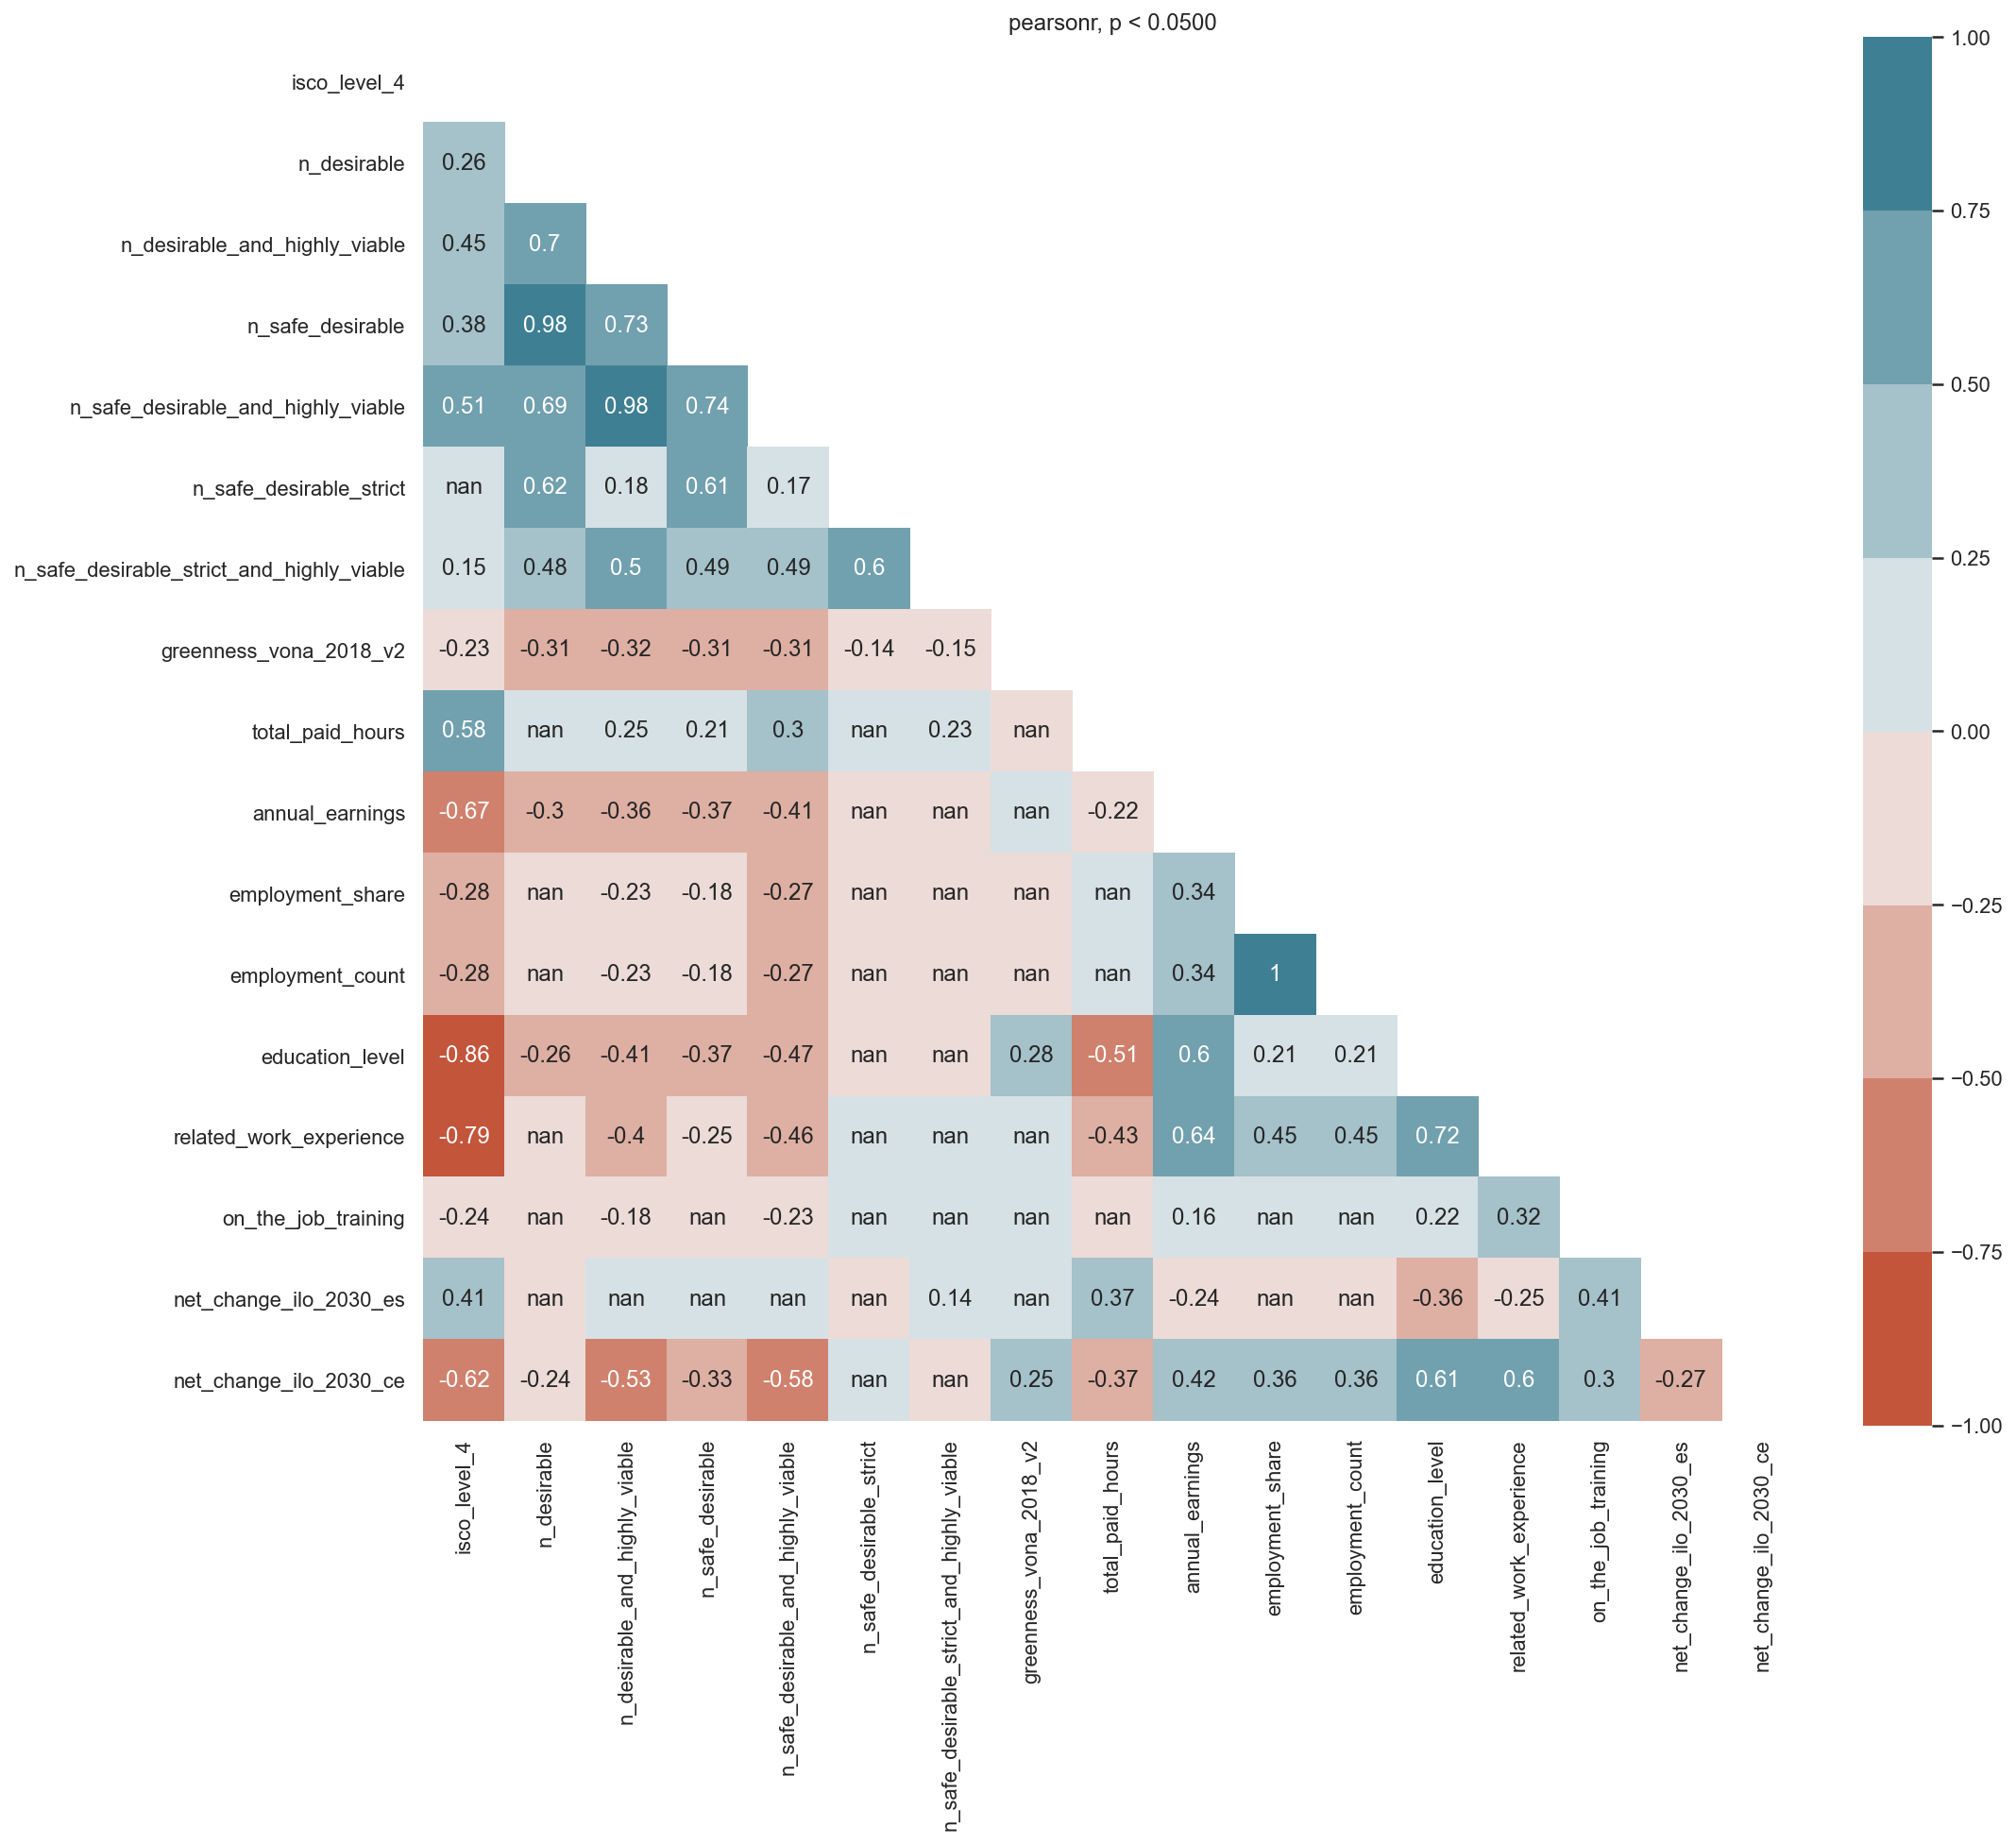

In [6]:
from src.visualization.visualize import correlation_matrix_plot

correlation_matrix_plot(
    df=df_merged,
    significance_level=0.05,
    figsize=(15, 15),
    function=pearsonr
)

### Regress greenness on n_transitions

In [7]:
reg_greenness = ols(
    formula="greenness_vona_2018_v2 ~ n_desirable",
    data=df_merged
).fit(cov_type='HC3')

Stargazer([reg_greenness])